# Chapter 5
# Numerical Integration

In many computational economic applications, one must compute the definite integral
of a real-valued function $f(x)$ with respect to a "weighting" function $w(x)$ over an interval
$I$ of $R^n$:

$$\int_I f(x)w(x) dx$$


The weighting function may be the identity function, $w(x) = 1$, in which case the integral represents
the area under the function $f(x)$. In other applications, $w(x)$ may be the probability
density of a random variable $\tilde X$, in which case the integral represents the expectation
of $f( \tilde X)$ when $I$ is the whole support of $\tilde X$.





In this notebook, we discuss three classes of numerical integration or numerical
quadrature methods<sup>1</sup>. All methods approximate the integral with a weighted sum of
function values:

$$\int_I f(x) w(x)dx \approx \sum_{i=0}^{n} w_i f(x_i)\thinspace .$$

<sup>1</sup>Quadrature is a historical mathematical term that means calculating an area.

The methods differ only in how the *quadrature weights* $w_i$ and the *quadrature nodes*
$x_i$ are chosen.

1. Newton-Cotes rules employ piecewise polynomial approximations to the integrand
2. Gaussian quadrature methods employ nodes and weights that satisfy moment matching conditions
3. Monte Carlo methods employ equally weighted “random” nodes

**Newton-Cotes** methods approximate the integrand $f$ between nodes
using low order polynomials, and sum the integrals of the polynomials to approximate
the integral of $f$. Newton-Cotes methods are easy to implement, but are not particularly
efficient for computing the integral of a smooth function.

**Gaussian quadrature**
methods choose the nodes and weights to satisfy moment matching conditions, and
are more powerful than Newton-Cotes methods if the integrand is smooth.

**Monte Carlo and quasi-Monte Carlo integration** methods use "random" or "equidistributed"
nodes, and are simple to implement and are especially useful if the integration domain
is of high dimension or irregularly shaped.

In [1]:
import math
import numpy as np
import scipy.linalg as la
from scipy.special import gammaln
import sympy as sym
sym.init_printing()
from scipy import integrate


# Install a conda package in the current Jupyter kernel
#import sys
#!conda install --yes --prefix {sys.prefix} seaborn numba

import matplotlib.pyplot as plt
import numpy as np
from functools import reduce

In [2]:
def ckron(*arrays):
    """
    Repeatedly applies the np.kron function to an arbitrary number of
    input arrays
    Parameters
    ----------
    *arrays : tuple/list of np.ndarray
    Returns
    -------
    out : np.ndarray
        The result of repeated kronecker products
    Notes
    -----
    Based of original function `ckron` in CompEcon toolbox by Miranda
    and Fackler
    References
    ----------
    Miranda, Mario J, and Paul L Fackler. Applied Computational
    Economics and Finance, MIT Press, 2002.
    """
    return reduce(np.kron, arrays)

def gridmake(*arrays):
    """
    TODO: finish this docstring
    Notes
    -----
    Based of original function ``gridmake`` in CompEcon toolbox by
    Miranda and Fackler
    References
    ----------
    Miranda, Mario J, and Paul L Fackler. Applied Computational Economics
    and Finance, MIT Press, 2002.
    """
    if all([i.ndim == 1 for i in arrays]):
        d = len(arrays)
        if d == 2:
            out = _gridmake2(*arrays)
        else:
            out = _gridmake2(arrays[0], arrays[1])
            for arr in arrays[2:]:
                out = _gridmake2(out, arr)

        return out
    else:
        raise NotImplementedError("Come back here")
        
def _gridmake2(x1, x2):
    """
    TODO: finish this docstring
    Notes
    -----
    Based of original function ``gridmake2`` in CompEcon toolbox by
    Miranda and Fackler
    References
    ----------
    Miranda, Mario J, and Paul L Fackler. Applied Computational Economics
    and Finance, MIT Press, 2002.
    """
    if x1.ndim == 1 and x2.ndim == 1:
        return np.column_stack([np.tile(x1, x2.shape[0]),
                               np.repeat(x2, x1.shape[0])])
    elif x1.ndim > 1 and x2.ndim == 1:
        first = np.tile(x1, (x2.shape[0], 1))
        second = np.repeat(x2, x1.shape[0])
        return np.column_stack([first, second])
    else:
        raise NotImplementedError("Come back here")        

def _qnwtrap1(n, a, b):
    """
    Compute univariate trapezoid rule quadrature nodes and weights
    Parameters
    ----------
    n : int
        The number of nodes
    a : int
        The lower endpoint
    b : int
        The upper endpoint
    Returns
    -------
    nodes : np.ndarray(dtype=float)
        An n element array of nodes
    nodes : np.ndarray(dtype=float)
        An n element array of weights
    Notes
    -----
    Based of original function ``qnwtrap1`` in CompEcon toolbox by
    Miranda and Fackler
    References
    ----------
    Miranda, Mario J, and Paul L Fackler. Applied Computational
    Economics and Finance, MIT Press, 2002.
    """
    if n < 1:
        raise ValueError("n must be at least one")

    nodes = np.linspace(a, b, n)
    dx = nodes[1] - nodes[0]

    weights = dx * np.ones(n)
    weights[0] *= 0.5
    weights[-1] *= 0.5

    return nodes, weights
    
def _qnwsimp1(n, a, b):
    """
    Compute univariate Simpson quadrature nodes and weights
    Parameters
    ----------
    n : int
        The number of nodes
    a : int
        The lower endpoint
    b : int
        The upper endpoint
    Returns
    -------
    nodes : np.ndarray(dtype=float)
        An n element array of nodes
    nodes : np.ndarray(dtype=float)
        An n element array of weights
    Notes
    -----
    Based of original function ``qnwsimp1`` in CompEcon toolbox by
    Miranda and Fackler
    References
    ----------
    Miranda, Mario J, and Paul L Fackler. Applied Computational
    Economics and Finance, MIT Press, 2002.
    """
    if n % 2 == 0:
        print("WARNING qnwsimp: n must be an odd integer. Increasing by 1")
        n += 1

    nodes = np.linspace(a, b, n)
    dx = nodes[1] - nodes[0]
    weights = np.tile([2.0, 4.0], (n + 1) // 2)
    weights = weights[:n]
    weights[0] = weights[-1] = 1
    weights = (dx / 3.0) * weights

    return nodes, weights       
        
def _qnwlege1(n, a, b):
    """
    Compute univariate Guass-Legendre quadrature nodes and weights
    Parameters
    ----------
    n : int
        The number of nodes
    a : int
        The lower endpoint
    b : int
        The upper endpoint
    Returns
    -------
    nodes : np.ndarray(dtype=float)
        An n element array of nodes
    nodes : np.ndarray(dtype=float)
        An n element array of weights
    Notes
    -----
    Based of original function ``qnwlege1`` in CompEcon toolbox by
    Miranda and Fackler
    References
    ----------
    Miranda, Mario J, and Paul L Fackler. Applied Computational
    Economics and Finance, MIT Press, 2002.
    """
    # import ipdb; ipdb.set_trace()
    maxit = 100
    m = np.fix((n + 1) / 2.0).astype(int)
    xm = 0.5 * (b + a)
    xl = 0.5 * (b - a)
    nodes = np.zeros(n)

    weights = nodes.copy()
    i = np.arange(m, dtype='int')

    z = np.cos(np.pi * ((i + 1.0) - 0.25) / (n + 0.5))

    for its in range(maxit):
        p1 = 1.0
        p2 = 0.0
        for j in range(1, n+1):
            p3 = p2
            p2 = p1
            p1 = ((2 * j - 1) * z * p2 - (j - 1) * p3) / j

        pp = n * (z * p1 - p2)/(z * z - 1.0)
        z1 = z.copy()
        z = z1 - p1/pp
        if all(np.abs(z - z1) < 1e-14):
            break

    if its == maxit - 1:
        raise ValueError("Maximum iterations in _qnwlege1")

    nodes[i] = xm - xl * z
    nodes[- i - 1] = xm + xl * z

    weights[i] = 2 * xl / ((1 - z * z) * pp * pp)
    weights[- i - 1] = weights[i]

    return nodes, weights
        
def _make_multidim_func(one_d_func, n, *args):
    """
    A helper function to cut down on code repetition. Almost all of the
    code in qnwcheb, qnwlege, qnwsimp, qnwtrap is just dealing
    various forms of input arguments and then shelling out to the
    corresponding 1d version of the function.
    This routine does all the argument checking and passes things
    through the appropriate 1d function before using a tensor product
    to combine weights and nodes.
    Parameters
    ----------
    one_d_func : function
        The 1d function to be called along each dimension
    n : int or array_like(float)
        A length-d iterable of the number of nodes in each dimension
    args :
        These are the arguments to various qnw____ functions.  For the
        majority of the functions this is just a and b, but some differ.
    Returns
    -------
    func : function
        The multi-dimensional version of the parameter ``one_d_func``
    """
    args = list(args)
    n = np.asarray(n)
    args = list(map(np.asarray, args))

    if all([x.size == 1 for x in [n] + args]):
        return one_d_func(n, *args)

    d = n.size

    for i in range(len(args)):
        if args[i].size == 1:
            args[i] = np.repeat(args[i], d)

    nodes = []
    weights = []

    for i in range(d):
        ai = [x[i] for x in args]
        _1d = one_d_func(n[i], *ai)
        nodes.append(_1d[0])
        weights.append(_1d[1])

    weights = ckron(*weights[::-1])  # reverse ordered tensor product

    nodes = gridmake(*nodes)
    return nodes, weights

def qnwtrap(n, a, b):
    """
    Computes multivariate trapezoid rule quadrature nodes and weights.
    Parameters
    ----------
    n : int or array_like(float)
        A length-d iterable of the number of nodes in each dimension
    a : scalar or array_like(float)
        A length-d iterable of lower endpoints. If a scalar is given,
        that constant is repeated d times, where d is the number of
        dimensions
    b : scalar or array_like(float)
        A length-d iterable of upper endpoints. If a scalar is given,
        that constant is repeated d times, where d is the number of
        dimensions
    Returns
    -------
    nodes : np.ndarray(dtype=float)
        Quadrature nodes
    weights : np.ndarray(dtype=float)
        Weights for quadrature nodes
    Notes
    -----
    Based of original function ``qnwtrap`` in CompEcon toolbox by
    Miranda and Fackler
    References
    ----------
    Miranda, Mario J, and Paul L Fackler. Applied Computational
    Economics and Finance, MIT Press, 2002.
    """
    return _make_multidim_func(_qnwtrap1, n, a, b)

def _qnwnorm1(n):
    """
    Compute nodes and weights for quadrature of univariate standard
    normal distribution
    Parameters
    ----------
    n : int
        The number of nodes
    Returns
    -------
    nodes : np.ndarray(dtype=float)
        An n element array of nodes
    nodes : np.ndarray(dtype=float)
        An n element array of weights
    Notes
    -----
    Based of original function ``qnwnorm1`` in CompEcon toolbox by
    Miranda and Fackler
    References
    ----------
    Miranda, Mario J, and Paul L Fackler. Applied Computational
    Economics and Finance, MIT Press, 2002.
    """
    maxit = 100
    pim4 = 1 / np.pi**(0.25)
    m = np.fix((n + 1) / 2).astype(int)
    nodes = np.zeros(n)
    weights = np.zeros(n)

    for i in range(m):
        if i == 0:
            z = np.sqrt(2*n+1) - 1.85575 * ((2 * n + 1)**(-1 / 6.1))
        elif i == 1:
            z = z - 1.14 * (n ** 0.426) / z
        elif i == 2:
            z = 1.86 * z + 0.86 * nodes[0]
        elif i == 3:
            z = 1.91 * z + 0.91 * nodes[1]
        else:
            z = 2 * z + nodes[i-2]

        its = 0

        while its < maxit:
            its += 1
            p1 = pim4
            p2 = 0
            for j in range(1, n+1):
                p3 = p2
                p2 = p1
                p1 = z * math.sqrt(2.0/j) * p2 - math.sqrt((j - 1.0) / j) * p3

            pp = math.sqrt(2 * n) * p2
            z1 = z
            z = z1 - p1/pp
            if abs(z - z1) < 1e-14:
                break

        if its == maxit:
            raise ValueError("Failed to converge in _qnwnorm1")

        nodes[n - 1 - i] = z
        nodes[i] = -z
        weights[i] = 2 / (pp*pp)
        weights[n - 1 - i] = weights[i]

    weights /= math.sqrt(math.pi)
    nodes = nodes * math.sqrt(2.0)

    return nodes, weights

def qnwnorm(n, mu=None, sig2=None, usesqrtm=False):
    """
    Computes nodes and weights for multivariate normal distribution
    Parameters
    ----------
    n : int or array_like(float)
        A length-d iterable of the number of nodes in each dimension
    mu : scalar or array_like(float), optional(default=zeros(d))
        The means of each dimension of the random variable. If a scalar
        is given, that constant is repeated d times, where d is the
        number of dimensions
    sig2 : array_like(float), optional(default=eye(d))
        A d x d array representing the variance-covariance matrix of the
        multivariate normal distribution.
    Returns
    -------
    nodes : np.ndarray(dtype=float)
        Quadrature nodes
    weights : np.ndarray(dtype=float)
        Weights for quadrature nodes
    Notes
    -----
    Based of original function ``qnwnorm`` in CompEcon toolbox by
    Miranda and Fackler
    References
    ----------
    Miranda, Mario J, and Paul L Fackler. Applied Computational
    Economics and Finance, MIT Press, 2002.
    """
    n = np.asarray(n)
    d = n.size

    if mu is None:
        mu = np.zeros(d)
    else:
        mu = np.asarray(mu)

    if sig2 is None:
        sig2 = np.eye(d)
    else:
        sig2 = np.asarray(sig2).reshape(d, d)

    if all([x.size == 1 for x in [n, mu, sig2]]):
        nodes, weights = _qnwnorm1(n)
    else:
        nodes = []
        weights = []

        for i in range(d):
            _1d = _qnwnorm1(n[i])
            nodes.append(_1d[0])
            weights.append(_1d[1])

        nodes = gridmake(*nodes)
        weights = ckron(*weights[::-1])

    if usesqrtm:
        new_sig2 = la.sqrtm(sig2)
    else:  # cholesky
        new_sig2 = la.cholesky(sig2)

    if d > 1:
        nodes = nodes.dot(new_sig2) + mu  # Broadcast ok
    else:  # nodes.dot(sig) will not be aligned in scalar case.
        nodes = nodes * new_sig2 + mu

    return nodes.squeeze(), weights


## 5.3 Monte Carlo Integration

In numerical integration, methods such as the trapezoidal rule use a deterministic approach. Monte Carlo integration, on the other hand, employs a non-deterministic approach: each realization provides a different outcome.


![](https://upload.wikimedia.org/wikipedia/commons/thumb/2/20/MonteCarloIntegrationCircle.svg/440px-MonteCarloIntegrationCircle.svg.png)




Monte Carlo integration methods are motivated by the **Strong Law of Large Numbers.**

One version of the Law states that if $x_1, x_2, ..., x_n$ are independent realizations of a random variable $\tilde X$ and $f$ is a continuous function, then


$$\lim _{{n\to \infty }} \frac{1}{n} \sum_{i=1}^{n}  f(x_i) =  E f(\tilde X)$$

with probability one.

The Monte Carlo integration scheme is thus a simple one. To compute an approximation to the expectation of $f(\tilde X)$, one draws a random sample $x_1, x_2, ..., x_n$ from the distribution of $\tilde X$ and sets



$$  E f(\tilde X) \approx \frac{1}{n} \sum_{i=1}^{n}  f(x_i) $$


Monte Carlo integration uses uniform weights and “randomly” generated nodes. However, can we draw a truly random sample?

### Random Number Generators

Most numerical software packages provide a routine that generates pseudo-random variables
that are uniformly distributed on the interval [0; 1]. A uniform random number generator
is useful for generating random samples from other distributions. Suppose $\tilde X$ has a cumulative distribution function  

$$ F(x) = Pr( \tilde X \le x) $$


whose inverse has a well-defined closed form. If $\tilde U$ is uniformly distributed on $(0; 1)$, then
$F^{-1}( \tilde U)$ has the same distribution as $\tilde X$.

Most numerical software packages also provide an intrinsic routine that generates pseudorandom
standard normal variables. The routine may also be used to generate pseudo-random sequences of lognormal and multivariate normal variables.



A fundamental problem that arises with Monte Carlo integration is that it is almost impossible
to generate a truly random sample of variates for any distribution. Most compilers
and vector processing packages provide intrinsic routines for computing so-called random
numbers. These routines, however, employ iteration rules that generate a purely deterministic,
not random, sequence of numbers. In particular, if the generator is repeatedly initiated
at the same point, it will return the same sequence of "random" variates each time. About
all that can be said of numerical random number generators is that good ones will generate
sequences that appear to be random, in that they pass certain statistical tests for randomness.
For this reason, numerical random number generators are more accurately said to
generate sequences of "pseudo-random" rather than random numbers.

- numpy offers two intrinsic random number generators 

- np.random.rand(m,n) generates an matrix of numbers that are independently uniformly distributed on the interval


- np.random.randn(m,n) generates an matrix of numbers that are independently standard normally distributed

In [3]:
np.random.seed(123)

In [4]:
np.random.rand(4,3)

array([[0.69646919, 0.28613933, 0.22685145],
       [0.55131477, 0.71946897, 0.42310646],
       [0.9807642 , 0.68482974, 0.4809319 ],
       [0.39211752, 0.34317802, 0.72904971]])

In [5]:
np.random.randn(4,3)

array([[-0.67888615, -0.09470897,  1.49138963],
       [-0.638902  , -0.44398196, -0.43435128],
       [ 2.20593008,  2.18678609,  1.0040539 ],
       [ 0.3861864 ,  0.73736858,  1.49073203]])

In [6]:
#Example 1
np.random.seed(123)
nsample=10
xavg=2.0
xvec=np.random.randn(nsample,1)
xvec=xvec+xavg
sampleavg=np.sum(xvec)/nsample
print("The sample average is:", sampleavg)

The sample average is: 1.7304838896736723


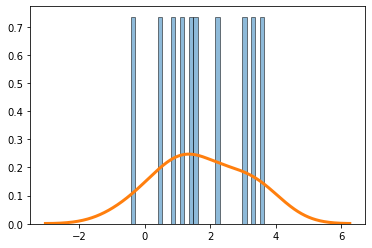

In [7]:
import statsmodels.api as sm
kde = sm.nonparametric.KDEUnivariate(xvec)
kde.fit() # Estimate the density

fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the histrogram
ax.hist(xvec, bins=30, density=True, label='Histogram from sample',
        zorder=5, edgecolor='k', alpha=0.5)

# Plot the KDE as fitted using the default arguments
ax.plot(kde.support, kde.density, lw=3, label='KDE from sample', zorder=10)

plt.show()

In [8]:
np.random.seed(123)
nsample=100
xavg=2.0
xvec=np.random.randn(nsample,1)
xvec=xvec+xavg
sampleavg=np.sum(xvec)/nsample
print("The sample average is:", sampleavg)

The sample average is: 2.02710907349036


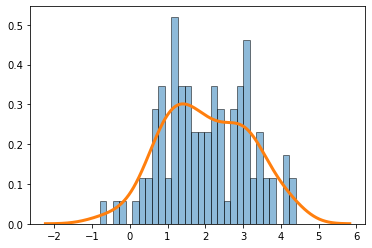

In [9]:
kde = sm.nonparametric.KDEUnivariate(xvec)
kde.fit() # Estimate the density

fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the histrogram
ax.hist(xvec, bins=30, density=True, label='Histogram from sample',
        zorder=5, edgecolor='k', alpha=0.5)

# Plot the KDE as fitted using the default arguments
ax.plot(kde.support, kde.density, lw=3, label='KDE from sample', zorder=10)

plt.show()

In [10]:
np.random.seed(123)
nsample=10000
xavg=2.0
xvec=np.random.randn(nsample,1)
xvec=xvec+xavg
sampleavg=np.sum(xvec)/nsample
print("The sample average is:", sampleavg)

The sample average is: 2.009711892291596


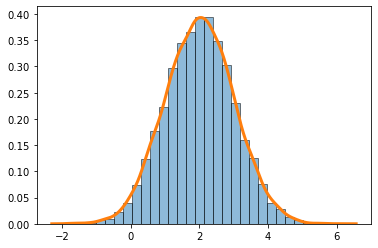

In [11]:
kde = sm.nonparametric.KDEUnivariate(xvec)
kde.fit() # Estimate the density

fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the histrogram
ax.hist(xvec, bins=30, density=True, label='Histogram from sample',
        zorder=5, edgecolor='k', alpha=0.5)

# Plot the KDE as fitted using the default arguments
ax.plot(kde.support, kde.density, lw=3, label='KDE from sample', zorder=10)

plt.show()

In [12]:
#Example 2
np.random.seed(123)
nsample=10000
xavg=2.0
xvec=np.random.randn(nsample,1)
xvec=xvec+xavg
xvec=1/xvec
sampleavg=np.sum(xvec)/nsample
print("The sample average is:", sampleavg)

The sample average is: 0.6348601314794019


In [13]:
#Example 3
np.random.seed(123)
nsample=10000
xavg=0.0
xsd=2.0
xvec=np.random.randn(nsample,1)
xvec=xsd*xvec+xavg
sampleavg=np.sum(xvec)/nsample
print("The sample average is:", sampleavg)
samplevar=np.sum(xvec*xvec)/nsample
samplevar=samplevar-sampleavg*sampleavg
print("The sample variance is:", samplevar)

The sample average is: 0.01942378458319191
The sample variance is: 3.984925066899208


Monte Carlo integration is easy to implement and may be preferred over Gaussian quadrature
if the a routine for computing the Gaussian mass points and probabilities is not readily
available or if the integration is over many dimensions. Monte Carlo integration, however, is
subject to a sampling error that cannot be bounded with certainty. The approximation can
be made more accurate, in a dubious statistical sense, by increasing the size of the random
sample, but this can be expensive if evaluating $f$ or generating the pseudo-random variate is
costly. Approximations generated by Monte Carlo integration will vary from one integration
to the next, unless initialized at the same point, making the use of Monte Carlo integration
in conjunction within other iterative schemes, such as dynamic programming or maximum
likelihood estimation, problematic. So-called quasi Monte-Carlo methods can circumvent
some of the problems associated with Monte-Carlo integration.

Quasi-Monte Carlo uses a low-discrepancy sequence such as the Halton sequence, the Sobol sequence, or the Faure sequence, whereas Monte Carlo uses a pseudo random sequence. The advantage of using low-discrepancy sequences is a faster rate of convergence. Quasi-Monte Carlo has a rate of convergence close to $O(1/N)$, whereas the rate for the Monte Carlo method is $O(N^{−0.5})$.






The Quasi-Monte Carlo method recently became popular in the area of mathematical finance or computational finance. In these areas, high-dimensional numerical integrals, where the integral should be evaluated within a threshold ε, occur frequently. Hence, the Monte Carlo method and the quasi-Monte Carlo method are beneficial in these situations.

https://en.wikipedia.org/wiki/Quasi-Monte_Carlo_method

## 5.4 Quasi-Monte Carlo Integration


Although Monte-Carlo integration methods originated using insights from probability
theory, recent extensions have severed that connection and, in the process, demonstrated
ways in which the methods can be improved. Monte-Carlo methods rely on
sequences $x_i$ with the property that


$$\lim _{{n\to \infty }} \frac{b-a}{n} \sum_{i=1}^{n}  f(x_i) =  \int_{a}^{b} f(x) dx$$


without regard to whether the sequences passes standard tests of randomness. Any sequence
that satisfies this condition for arbitrary (Riemann) integrable functions can be used to approximate an integral on [a; b]. Although the Law of Large Numbers assures us that this is true when the $x_i$ are independent and identically distributed random variables, other
sequences also satisfy this property. Indeed, it can be shown that sequences that are explicitly
non-random, but instead attempt to fill in space in a regular manner can often provide more
accurate approximations to definite integrals.


There are numerous schemes for generating equidistributed sequences, including **the Neiderreiter,
Weyl, and Haber sequences.**

All of the quadrature functions will use tensor products to generate nodes and
weights for integration over an arbitrary bounded interval $[a, b]$ in higher dimensional
spaces.

## 5.5 An Integration Toolbox
The toolbox accompanying the textbook includes four functions for computing
numerical integrals for general functions. Each takes three inputs ($n$, $a$, and $b$) and
generates appropriate nodes and weights. The functions `qnwtrap` and `qnwsimp` implement the Newton-Cotes trapezoid and Simpson's rule methods, `qnwlege` implements
Gauss-Legendre quadrature and `qnwequi` generates nodes and weights associated with
either equidistributed or pseudo-random sequences. The calling syntax is the same
for each and is illustrated with below with `qnwtrap`.




In [14]:
def qnwlege(n, a, b):
    """
    Computes multivariate Guass-Legendre  quadrature nodes and weights.
    Parameters
    ----------
    n : int or array_like(float)
        A length-d iterable of the number of nodes in each dimension
    a : scalar or array_like(float)
        A length-d iterable of lower endpoints. If a scalar is given,
        that constant is repeated d times, where d is the number of
        dimensions
    b : scalar or array_like(float)
        A length-d iterable of upper endpoints. If a scalar is given,
        that constant is repeated d times, where d is the number of
        dimensions
    Returns
    -------
    nodes : np.ndarray(dtype=float)
        Quadrature nodes
    weights : np.ndarray(dtype=float)
        Weights for quadrature nodes
    Notes
    -----
    Based of original function ``qnwlege`` in CompEcon toolbox by
    Miranda and Fackler
    References
    ----------
    Miranda, Mario J, and Paul L Fackler. Applied Computational
    Economics and Finance, MIT Press, 2002.
    """
    return _make_multidim_func(_qnwlege1, n, a, b)

In [15]:
def qnwequi(n, a, b, kind="N", equidist_pp=None):
    """
    Generates equidistributed sequences with property that averages
    value of integrable function evaluated over the sequence converges
    to the integral as n goes to infinity.
    Parameters
    ----------
    n : int
        Number of sequence points
    a : scalar or array_like(float)
        A length-d iterable of lower endpoints. If a scalar is given,
        that constant is repeated d times, where d is the number of
        dimensions
    b : scalar or array_like(float)
        A length-d iterable of upper endpoints. If a scalar is given,
        that constant is repeated d times, where d is the number of
        dimensions
    kind : string, optional(default="N")
        One of the following:
        - N - Neiderreiter (default)
        - W - Weyl
        - H - Haber
        - R - pseudo Random
    equidist_pp : array_like, optional(default=None)
        TODO: I don't know what this does
    Returns
    -------
    nodes : np.ndarray(dtype=float)
        Quadrature nodes
    weights : np.ndarray(dtype=float)
        Weights for quadrature nodes
    Notes
    -----
    Based of original function ``qnwequi`` in CompEcon toolbox by
    Miranda and Fackler
    References
    ----------
    Miranda, Mario J, and Paul L Fackler. Applied Computational
    Economics and Finance, MIT Press, 2002.
    """
    if equidist_pp is None:
        equidist_pp = np.sqrt(np.array(list(sym.primerange(0, 7920))))

    n, a, b = list(map(np.atleast_1d, list(map(np.asarray, [n, a, b]))))

    d = max(list(map(len, [n, a, b])))
    n = np.prod(n)

    if a.size == 1:
        a = np.repeat(a, d)

    if b.size == 1:
        b = np.repeat(b, d)

    i = np.arange(1, n + 1)

    if kind.upper() == "N":  # Neiderreiter
        j = 2.0 ** (np.arange(1, d+1) / (d+1))
        nodes = np.outer(i, j)
        nodes = (nodes - np.fix(nodes)).squeeze()
    elif kind.upper() == "W":  # Weyl
        j = equidist_pp[:d]
        nodes = np.outer(i, j)
        nodes = (nodes - np.fix(nodes)).squeeze()
    elif kind.upper() == "H":  # Haber
        j = equidist_pp[:d]
        nodes = np.outer(i * (i+1) / 2, j)
        nodes = (nodes - np.fix(nodes)).squeeze()
    elif kind.upper() == "R":  # pseudo-random
        nodes = np.random.rand(n, d).squeeze()
    else:
        raise ValueError("Unknown sequence requested")

    # compute nodes and weights
    r = b - a
    nodes = a + nodes * r
    weights = (np.prod(r) / n) * np.ones(n)

    return nodes, weights

For example, to compute the definite integral of $exp(x)$ on $[-1, 2]$ using a 10 point
**trapezoid rule** one would write:

In [16]:
x,w = qnwtrap(10,-1,2)
print(x.shape, w.shape)
integral = w.T@np.exp(x)
integral

(10,) (10,)


To compute the definite integral using a 100 point **Neiderrieter rule** one would instead generate
the nodes and weights as follows:

In [17]:
[x,w] = qnwequi(100,-1,2,'N')
print(x.shape, w.shape)
integral = w.T@np.exp(x)
integral

(100,) (100,)


Each of the aforementioned routines also may be used to compute definite integrals of
real-valued multivariate functions over bounded intervals in higher dimensional spaces. The
routines generate nodes and weights for higher dimensional quadrature by forming the tensor
products of univariate nodes and weights. For example, suppose one wished to compute the
integral of $exp(x_1 + x_2)$ over the rectangle $[1, 2] \times [0, 5]$ in $R^2$. One could call `qnwtrap` to
construct a grid of, say, 200 quadrature nodes produced by taking the cross-product of 10
nodes in the $x_1$ direction and 20 nodes in the $x_2$ direction:

In [18]:
[x,w] = qnwtrap([10, 20],[1, 0],[2, 5])
print(x.shape, w.shape)
integral = w.T@np.exp(x[:,0]+x[:,1])
integral

(200, 2) (200,)


A similar calling syntax is used for qnwsimp, and qnwlege.

The calling syntax for qnwequi when performing multidimensional integration requires
$n$ to be an integer indicating the the total number of integration nodes. Thus, to compute
the definite integral using a 10000 point **Neiderrieter rule** one would generate the nodes and
weights as follows:

In [19]:
[x,w] = qnwequi(10000,[1, 0],[2, 5],'N');
print(x.shape, w.shape)
integral = w.T@np.exp(x[:,0]+x[:,1]);
integral

(10000, 2) (10000,)


In addition to the general integration routines, there are
several functions for computing Gaussian nodes and weights associated with common probability
distribution functions. The routine qnwnorm generates the Gaussian quadrature nodes
and weights for normal random variables. For univariate normal distributions, the calling
syntax takes the form

`[x,w] = qnwnorm(n,mu,var)`

where x are the nodes, w are the probability weights, n is the number nodes and weights,
mu the mean of the distribution, and var is the variance of the distribution. If mu and var
are omitted, the mean and variance are assumed to be 0 and 1, respectively. For example,
suppose one wanted to compute the expectation of $exp( \tilde X)$ where $\tilde X$
is normally distributed
with mean 2 and variance 4. An approximate expectation could be computed using the
following code:

In [20]:
[x,w] = qnwnorm(3,2,4)
print(x.shape,w.shape)
expectation = w.T@np.exp(x)
expectation

(3,) (3,)


The routine qnwnorm also generates nodes and weights for multivariate normal random
variables. For example, suppose one wished to compute the expectation of $exp( \tilde X_1 + \tilde X_2 )$
where $\tilde X$ and $\tilde X$ are jointly normal with  $E \tilde X_1  = 3 $, $E \tilde X_2 = 4$, $V \tilde X_1 = 2$, $V \tilde X_2 = 4$, and $Cov( \tilde X_1,\tilde X_2) = -1 $.

One could then invoke `qnwnorm` to construct a grid of 150 Gaussian quadrature nodes as the cross-product of 10 nodes in the $x_1$ direction and 15 nodes in the $x_2$ direction, and then form the weighted sum of the assigned weights and function values at the nodes:




In [21]:
[x,w] = qnwnorm([10, 15],[3, 4],[[2, -1], [-1, 4]])
print(x.shape,w.shape)
expectation = w.T@np.exp( x[:,0]+x[:,1] )
expectation

(150, 2) (150,)


## 5.6 Simulation Examples

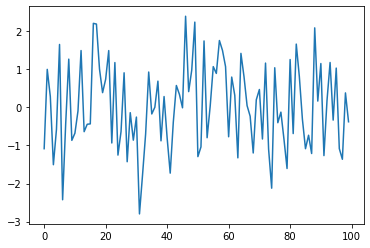

In [22]:
%matplotlib inline

#Let's generate and plot a White Noise process drawn from the standard normal
np.random.seed(123)
x = np.random.randn(100)
plt.plot(x)
plt.show()

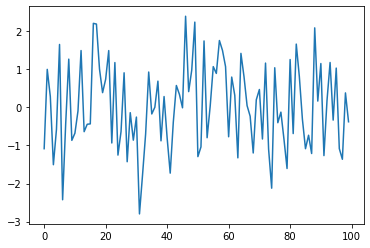

In [23]:
#Let's generate and plot the same White Noise process with a for-loop

np.random.seed(123)

ts_length = 100
ϵ_values = []   # Empty list, that is going to be filled with the random draws

for i in range(ts_length):
    e = np.random.randn()
    ϵ_values.append(e)

plt.plot(ϵ_values)
plt.show()

In [24]:
#We can create a function that will generate and plot a White Noise process.
#Also, we can decide which random number generator to use

def generate_data(n, generator_type):
    ϵ_values = []
    for i in range(n):
        if generator_type == 'U':
            e = np.random.uniform(0, 1)
        elif generator_type == 'N':
            e = np.random.randn()
        ϵ_values.append(e)
    return ϵ_values

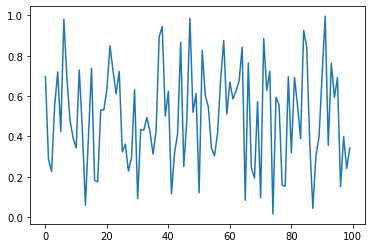

In [25]:
#Generate a sample drawn from the Uniform distribution
np.random.seed(123)
data = generate_data(100, 'U')
plt.plot(data)
plt.show()

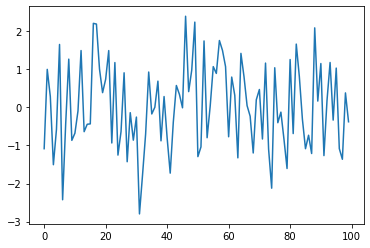

In [26]:
#Generate a sample drawn from the Standard Normal distribution
np.random.seed(123)
data = generate_data(100, 'N')
plt.plot(data)
plt.show()

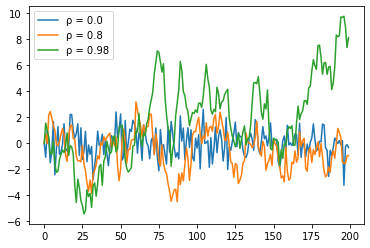

In [27]:
#Generate a non-iid sample (this is useful to simulate artificial time series)
np.random.seed(123)

#We consider a AR(1) model, with autocorrelation parameter ρ
rhovec = [0.0, 0.8, 0.98]
ts_length = 200

for rho in rhovec:
    x_values = []
    current_x = 0
    for i in range(ts_length):
        x_values.append(current_x)
        current_x = rho * current_x + np.random.randn()
    plt.plot(x_values, label=f'ρ = {rho}')
plt.legend()
plt.show()

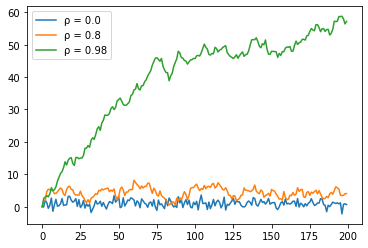

In [28]:
#Generate a non-iid sample (this is useful to simulate artificial time series)
np.random.seed(123)

#We consider a AR(1) model, with autocorrelation parameter ρ and a non-zero average
rhovec = [0.0, 0.8, 0.98]
ts_length = 200
mu=1.0

#We have to be careful about the "burn-in" period
#The first part of the simulation might have to be dropped
for rho in rhovec:
    x_values = []
    current_x = 0
    for i in range(ts_length):
        x_values.append(current_x)
        current_x = mu + rho * current_x + np.random.randn()
    plt.plot(x_values, label=f'ρ = {rho}')
plt.legend()
plt.show()